In [1]:
%reset

# 1. Imports

In [1]:
import mne
import time
import os
from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import custom_modules.xdf_to_fif_converter as xtfc
import custom_modules.preprocessing_ptu as prep
import custom_modules.file_handling as  fh
import custom_modules.processing_ptu as proc
import custom_modules.classification_ptu as clas
import custom_modules.visualization_ptu as visu

import importlib
importlib.reload(xtfc)
importlib.reload(prep)
importlib.reload(fh)
importlib.reload(proc)
importlib.reload(clas)
importlib.reload(visu)

<module 'custom_modules.visualization_ptu' from 'C:\\Users\\peter\\Documents\\Code\\master-thesis\\03_analysis\\custom_modules\\visualization_ptu.py'>

# 2. Constants

In [2]:
data_path = 'D:/Diplomarbeit_data/eeg/'
subjects = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07' , 'A08', 'A09', 'A10']
trial_type_markers = ['LTR-s', 'LTR-l','RTL-s', 'RTL-l', 'TTB-s', 'TTB-l', 'BTT-s', 'BTT-l']

# Paths to interface files:
# path_cue_aligned_resampled = '2023_03_22_epoched_cue_aligned'
# path_movement_aligned_resampled = '2023_03_22_epoched_movement_aligned'
# path_cue_aligned_not_resampled = '2023_03_22_epoched_cue_aligned_not_resampled'
# path_movement_aligned_not_resampled = '2023_03_22_epoched_movement_aligned_not_resampled'

path_cue_aligned_resampled = '2023_05_24_epoched_cue_aligned'
path_movement_aligned_resampled = '2023_05_24_epoched_movement_aligned'
path_cue_aligned_not_resampled = '2023_05_24_epoched_cue_aligned_not_resampled'
path_movement_aligned_not_resampled = '2023_05_24_epoched_movement_aligned_not_resampled'

path_to_results = 'D:/Diplomarbeit_data/eeg/results'
path_to_figs = 'D:/Diplomarbeit_data/eeg/figs'

__spec__ = None # For multiprocessing
mne.set_log_level('WARNING') #'INFO' 'WARNING'

sns.set_context('paper')

## 2.1. Helper functions

In [3]:
def two_sample_permutation_test(pop1, pop2, n_perm=10000):
    from scipy.stats import ttest_ind, ttest_rel

    # Perform permutation test on the two populations:
    n1, n2 = len(pop1), len(pop2)
    combined = np.hstack((pop1, pop2))
    combined = combined.reshape((1,len(combined)))

    # Create a matrix with n_perm rows and permute the values of each row:
    values = np.repeat(combined, n_perm, axis=0)
    perm_vals = np.apply_along_axis(np.random.permutation, axis=1, arr=values)

    # Split values again:
    perm_pop1 = perm_vals[:,:n1]
    perm_pop2 = perm_vals[:,n1:]

    # Apply 2 sample t-test:
    _stat, _pval = ttest_rel(perm_pop1, perm_pop2, axis=1)

    orig_stat, orig_p = ttest_rel(pop1, pop2) #ttest_rel(pop1, pop2) #
    # Sort stats:
    _stat.sort()
    # print(_stat.shape)

    # Check how many values in stats are bigger or samller than the original statistic
    stats_above = _stat >= orig_stat
    stats_below = _stat <= orig_stat

    # Get the number of stats that are bigger than the original statistic:
    ids_above = stats_above.sum()
    ids_below = stats_below.sum()

    # Get proporotion of idcs that are bigger than original statistic:
    p_above = ids_above / n_perm
    p_below = ids_below / n_perm

    # if True:
    #     return _stat, orig_stat
    return min(p_above, p_below)

def perm_helper(shorts_per_s, longs_per_s):
    res = []
    for i in range(shorts_per_s.shape[1]):
        res.append(two_sample_permutation_test(shorts_per_s[:,i], longs_per_s[:,i]))
        if i % 10 == 0:
            print(i)

    return res

In [4]:
def one_sample_permutation_test(diff_pop, n_perm=10000):
    from scipy.stats import ttest_1samp

    # Perform permutation test on the two populations:
    n = len(diff_pop)
    sign_list = [-1, 1]

    # Create a random 1, -1 matrix with size len(vals) x n_perm
    signs = np.random.choice(sign_list, size=(len(diff_pop), n_perm))

    # Get absolute values of the difference population:
    abs_vals = np.array(np.abs(diff_pop))
    abs_vals = np.reshape(abs_vals, (len(abs_vals), 1))
    vals_rep = np.repeat(abs_vals, n_perm, axis=1)
    perm_vals = vals_rep * signs

    # Apply 1 sample t-test:
    _stat, _pval = ttest_1samp(perm_vals, axis=0, popmean=0)
    # _stat = np.abs(_stat)

    orig_stat, orig_p = ttest_1samp(diff_pop, popmean=0) #ttest_rel(pop1, pop2) #
    # Sort stats:
    _stat.sort()
    # print(_stat.shape, end='\r')

    # Check how many values in stats are bigger or samller than the original statistic
    stats_above = _stat > orig_stat
    stats_below = _stat < orig_stat

    # Get the number of stats that are bigger than the original statistic:
    ids_above = stats_above.sum()
    ids_below = stats_below.sum()

    # Get proporotion of idcs that are bigger than original statistic:
    p_above = ids_above / n_perm
    p_below = ids_below / n_perm

    return min(p_above, p_below)

In [5]:
def one_sided_one_sample_perm(pop, pop_mean=0, n_perm=10000):
    from scipy.stats import ttest_1samp

    # Perform permutation test on the two populations:
    n = len(pop)
    sign_list = [-1, 1]

    # Create a random 1, -1 matrix with size len(vals) x n_perm
    signs = np.random.choice(sign_list, size=(len(pop), n_perm))

    # Get difference population:
    diff_pop = pop - pop_mean
    # Get absolute values of the population:
    abs_vals = np.array(np.abs(diff_pop))
    abs_vals = np.reshape(abs_vals, (len(abs_vals), 1))
    vals_rep = np.repeat(abs_vals, n_perm, axis=1)
    perm_vals = vals_rep * signs

    # Apply 1 sample t-test:
    _stat, _pval = ttest_1samp(perm_vals, axis=0, popmean=0)
    # _stat = np.abs(_stat)

    orig_stat, orig_p = ttest_1samp(diff_pop, popmean=0) #ttest_rel(pop1, pop2) #
    # Sort stats:
    _stat.sort()
    # print(_stat.shape, end='\r')
    # Check how many values in stats are bigger than the original statistic
    stats_above = _stat >= orig_stat

    # Get the number of stats that are bigger than the original statistic:
    ids_above = stats_above.sum()

    # Get proporotion of idcs that are bigger than original statistic:
    pval = ids_above / n_perm

    return pval

In [6]:
def get_smoothed_timings(alignment=type):
    path_to_results = 'D:/Diplomarbeit_data/eeg/results'
    path_to_figs = 'D:/Diplomarbeit_data/eeg/figs'

    # Load timing results:
    timings_cue = [np.load(f'{path_to_results}/timings-cue_{sbj}_{alignment}.npy') for sbj in subjects]
    timings_release = [np.load(f'{path_to_results}/timings-release_{sbj}_{alignment}.npy') for sbj in subjects]
    timings_touch = [np.load(f'{path_to_results}/timings-touch_{sbj}_{alignment}.npy') for sbj in subjects]

    # Add all timings to np arary:
    timings_cue_np = np.hstack(timings_cue)
    timings_release_np = np.hstack(timings_release)
    timings_touch_np = np.hstack(timings_touch)

    # Align release/touch to the cue and difference between release touch:
    diff_cue_release = timings_release_np - timings_cue_np
    diff_cue_touch = timings_touch_np - timings_cue_np
    diff_release_touch = timings_touch_np - timings_release_np

    def _gauss(n=55,b=1):
        r = range(-int(n/2),int(n/2)+1)
        return [np.exp(-float(x)**2/(2*b**2)) for x in r]

    # Create smoothed timings for plotting in grand averages:
    # Load sample epoch:
    # Load example epo for channels list:
    epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

    # Get cue, movement onset, movement stop histograms:
    if alignment == 'cue-aligned':
        # Make "histogram" of difference between movement onset and cue-alignment:
        bins=np.arange(epochs.tmin, epochs.tmax, 1/epochs.info['sfreq'])
        diff_cue_release += 2.0
        diff_cue_touch += 2.0

        hist_cue_release = np.histogram(diff_cue_release, bins=bins, range=None)
        hist_cue_touch = np.histogram(diff_cue_touch, bins=bins, range=None)

        l_kernel = 55
        kernel = _gauss(n=l_kernel, b=0.1*epochs.info['sfreq'])

        smoothed_cue_release = np.convolve(hist_cue_release[0], kernel, 'same')
        smoothed_cue_touch = np.convolve(hist_cue_touch[0], kernel, 'same')

        smoothed_cue_release = (smoothed_cue_release - smoothed_cue_release.min()) / (smoothed_cue_release.max() - smoothed_cue_release.min())
        smoothed_cue_touch = (smoothed_cue_touch - smoothed_cue_touch.min()) / (smoothed_cue_touch.max() - smoothed_cue_touch.min())
        return smoothed_cue_release, smoothed_cue_touch

    if alignment == 'movement-aligned':
        # Make "histogram" of difference between movement onset and cue-alignment:
        bins=np.arange(epochs.tmin, epochs.tmax, 1/epochs.info['sfreq'])
        diffs_cue_release = np.array(diff_cue_release) * (-1.0)
        diffs_release_touch = np.array(diff_release_touch)

        hist_cue_release = np.histogram(diffs_cue_release, bins=bins, range=None)
        hist_release_touch = np.histogram(diffs_release_touch, bins=bins, range=None)

        l_kernel = 55
        kernel = _gauss(n=l_kernel, b=0.1*epochs.info['sfreq'])

        smoothed_cue_release = np.convolve(hist_cue_release[0], kernel, 'same')
        smoothed_release_touch = np.convolve(hist_release_touch[0], kernel, 'same')

        smoothed_cue_release = (smoothed_cue_release - smoothed_cue_release.min()) / (smoothed_cue_release.max() - smoothed_cue_release.min())
        smoothed_release_touch = (smoothed_release_touch - smoothed_release_touch.min()) / (smoothed_release_touch.max() - smoothed_release_touch.min())

        return smoothed_cue_release, smoothed_release_touch


# 3. Temporal results

## 3.1. Timings overall

In [110]:
path_to_results = 'D:/Diplomarbeit_data/eeg/results'
path_to_figs = 'D:/Diplomarbeit_data/eeg/figs'

# name is like timings-cue/release/touch_sbj_alignment.npy
alignment = 'cue-aligned' # 'movement-aligned'


# Load timing results:
timings_cue = [np.load(f'{path_to_results}/timings-cue_{sbj}_{alignment}.npy') for sbj in subjects]
timings_release = [np.load(f'{path_to_results}/timings-release_{sbj}_{alignment}.npy') for sbj in subjects]
timings_touch = [np.load(f'{path_to_results}/timings-touch_{sbj}_{alignment}.npy') for sbj in subjects]

# Add all timings to np arary:
timings_cue_np = np.hstack(timings_cue)
timings_release_np = np.hstack(timings_release)
timings_touch_np = np.hstack(timings_touch)

# Align release/touch to the cue and difference between release touch:
diff_cue_release = timings_release_np - timings_cue_np
diff_cue_touch = timings_touch_np - timings_cue_np
diff_release_touch = timings_touch_np - timings_release_np



In [111]:
def _gauss(n=55,b=1):
    r = range(-int(n/2),int(n/2)+1)
    return [np.exp(-float(x)**2/(2*b**2)) for x in r]

# Create smoothed timings for plotting in grand averages:
# Load sample epoch:
# Load example epo for channels list:
epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

# Get cue, movement onset, movement stop histograms:
if alignment == 'cue-aligned':
    # Make "histogram" of difference between movement onset and cue-alignment:
    bins=np.arange(epochs.tmin, epochs.tmax, 1/epochs.info['sfreq'])
    diff_cue_release += 2.0
    diff_cue_touch += 2.0

    hist_cue_release = np.histogram(diff_cue_release, bins=bins, range=None)
    hist_cue_touch = np.histogram(diff_cue_touch, bins=bins, range=None)

    l_kernel = 55
    kernel = _gauss(n=l_kernel, b=0.1*epochs.info['sfreq'])

    smoothed_cue_release = np.convolve(hist_cue_release[0], kernel, 'same')
    smoothed_cue_touch = np.convolve(hist_cue_touch[0], kernel, 'same')

    smoothed_cue_release = (smoothed_cue_release - smoothed_cue_release.min()) / (smoothed_cue_release.max() - smoothed_cue_release.min())
    smoothed_cue_touch = (smoothed_cue_touch - smoothed_cue_touch.min()) / (smoothed_cue_touch.max() - smoothed_cue_touch.min())


if alignment == 'movement-aligned':
    # Make "histogram" of difference between movement onset and cue-alignment:
    bins=np.arange(epochs.tmin, epochs.tmax, 1/epochs.info['sfreq'])
    diffs_cue_release = np.array(diff_cue_release) * (-1.0)
    diffs_release_touch = np.array(diff_release_touch)

    hist_cue_release = np.histogram(diffs_cue_release, bins=bins, range=None)
    hist_release_touch = np.histogram(diffs_release_touch, bins=bins, range=None)

    l_kernel = 55
    kernel = _gauss(n=l_kernel, b=0.1*epochs.info['sfreq'])

    smoothed_cue_release = np.convolve(hist_cue_release[0], kernel, 'same')
    smoothed_release_touch = np.convolve(hist_release_touch[0], kernel, 'same')

    smoothed_cue_release = (smoothed_cue_release - smoothed_cue_release.min()) / (smoothed_cue_release.max() - smoothed_cue_release.min())
    smoothed_release_touch = (smoothed_release_touch - smoothed_release_touch.min()) / (smoothed_release_touch.max() - smoothed_release_touch.min())

## 3.2. Timings short v long

In [224]:
path_to_results = 'D:/Diplomarbeit_data/eeg/results'

# name is like timings-cue/release/touch_sbj_alignment.npy
alignment = 'cue-aligned' # 'movement-aligned'

# Load timing results:
timings_cue_l = [np.load(f'{path_to_results}/timings-cue-l_{sbj}_{alignment}.npy') for sbj in subjects]
timings_release_l = [np.load(f'{path_to_results}/timings-release-l_{sbj}_{alignment}.npy') for sbj in subjects]
timings_touch_l = [np.load(f'{path_to_results}/timings-touch-l_{sbj}_{alignment}.npy') for sbj in subjects]

timings_cue_s = [np.load(f'{path_to_results}/timings-cue-s_{sbj}_{alignment}.npy') for sbj in subjects]
timings_release_s = [np.load(f'{path_to_results}/timings-release-s_{sbj}_{alignment}.npy') for sbj in subjects]
timings_touch_s = [np.load(f'{path_to_results}/timings-touch-s_{sbj}_{alignment}.npy') for sbj in subjects]

# Add all timings to np arary:
timings_cue_l_np = np.hstack(timings_cue_l)
timings_release_l_np = np.hstack(timings_release_l)
timings_touch_l_np = np.hstack(timings_touch_l)

timings_cue_s_np = np.hstack(timings_cue_s)
timings_release_s_np = np.hstack(timings_release_s)
timings_touch_s_np = np.hstack(timings_touch_s)

# Align release/touch to the cue and difference between release touch:
diff_cue_release_l = timings_release_l_np - timings_cue_l_np
diff_cue_touch_l = timings_touch_l_np - timings_cue_l_np
diff_release_touch_l = timings_touch_l_np - timings_release_l_np

diff_cue_release_s = timings_release_s_np - timings_cue_s_np
diff_cue_touch_s = timings_touch_s_np - timings_cue_s_np
diff_release_touch_s = timings_touch_s_np - timings_release_s_np

# Get mean for each subject:
mean_cue_l = np.array([np.mean(entry) for entry in timings_cue_l])
mean_release_l = np.array([np.mean(entry) for entry in timings_release_l])
mean_touch_l = np.array([np.mean(entry) for entry in timings_touch_l])

mean_cue_s = np.array([np.mean(entry) for entry in timings_cue_s])
mean_release_s = np.array([np.mean(entry) for entry in timings_release_s])
mean_touch_s = np.array([np.mean(entry) for entry in timings_touch_s])

mean_cue_release_l = mean_release_l - mean_cue_l
mean_cue_touch_l = mean_touch_l - mean_cue_l
mean_release_touch_l = mean_touch_l - mean_release_l

mean_cue_release_s = mean_release_s - mean_cue_s
mean_cue_touch_s = mean_touch_s - mean_cue_s
mean_release_touch_s = mean_touch_s - mean_release_s

Mean short: 1.3978504122770965
STD short: 0.6984796763617613
Mean long: 1.3672009195999297
STD long: 0.6810952434206587
-----------------
Mean short: 2.177200914407531
STD short: 0.7303325495720485
Mean long: 2.2748453132437207
STD long: 0.7562084529976855
-----------------
Mean short: 0.7793505021304347
STD short: 0.3946001251262587
Mean long: 0.907644393643791
STD long: 0.3690661123693939
(10000,)
pval cue-release: 0.2003
(10000,)
pval cue-touch: 0.0002
(10000,)
pval release-touch: 0.0


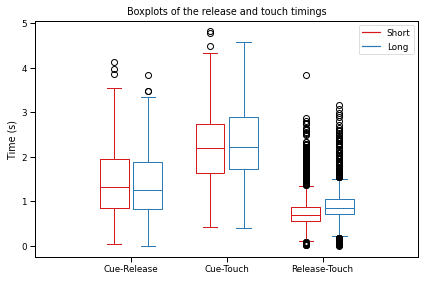

In [225]:
# create 2 - sample a 3-Dim array, that measures
# the summer and winter rain fall amount
short = [diff_cue_release_s, diff_cue_touch_s, diff_release_touch_s]
long = [diff_cue_release_l, diff_cue_touch_l, diff_release_touch_l]

# the list named ticks, summarizes or groups
# the summer and winter rainfall as low, mid
# and high
ticks = ['Cue-Release', 'Cue-Touch', 'Release-Touch']

short_plot = plt.boxplot(short, positions=np.array(np.arange(len(short)))*2.0-0.35, widths=0.6)
long_plot = plt.boxplot(long, positions=np.array(np.arange(len(long)))*2.0+0.35, widths=0.6)

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()


# setting colors for each groups
define_box_properties(short_plot, '#D7191C', 'Short')
define_box_properties(long_plot, '#2C7BB6', 'Long')

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)

# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

# set the limit for y axis
# plt.ylim(0, 50)
plt.ylabel('Time (s)')

# set the title
plt.title('Boxplots of the release and touch timings')

plt.tight_layout()
plt.savefig(f'{path_to_figs}/boxplot_timings.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_cue_release_s)}')
print(f'STD short: {np.std(diff_cue_release_s)}')
print(f'Mean long: {np.mean(diff_cue_release_l)}')
print(f'STD long: {np.std(diff_cue_release_l)}')
print('-----------------')
print(f'Mean short: {np.mean(diff_cue_touch_s)}')
print(f'STD short: {np.std(diff_cue_touch_s)}')
print(f'Mean long: {np.mean(diff_cue_touch_l)}')
print(f'STD long: {np.std(diff_cue_touch_l)}')
print('-----------------')
print(f'Mean short: {np.mean(diff_release_touch_s)}')
print(f'STD short: {np.std(diff_release_touch_s)}')
print(f'Mean long: {np.mean(diff_release_touch_l)}')
print(f'STD long: {np.std(diff_release_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval cue-release: {two_sample_permutation_test(diff_cue_release_s, diff_cue_release_l)}')
print(f'pval cue-touch: {two_sample_permutation_test(diff_cue_touch_s, diff_cue_touch_l)}')
print(f'pval release-touch: {two_sample_permutation_test(diff_release_touch_s, diff_release_touch_l)}')

Mean short: 1.4117481649938781
STD short: 0.4131514509805501
Mean long: 1.3806597268377119
STD long: 0.41903766086054883
-----------------
Mean short: 2.195187881205675
STD short: 0.549323523757525
Mean long: 2.291765010906056
STD long: 0.568807701592018
-----------------
Mean short: 0.7834397162117966
STD short: 0.15600782037726585
Mean long: 0.9111052840683442
STD long: 0.17188963640989444
(10000,)
pval cue-release: 0.8678
(10000,)
pval cue-touch: 0.7202
(10000,)
pval release-touch: 0.1216
pval cue-release: 0.0972
pval cue-touch: 0.0038
pval release-touch: 0.0021
pval cue-release: 0.10546875
pval cue-touch: 0.00390625
pval release-touch: 0.001953125


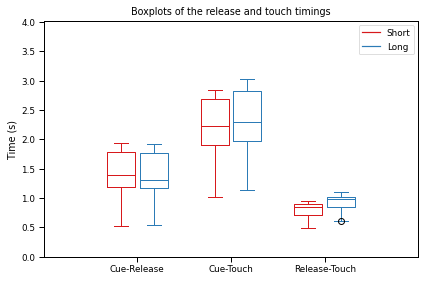

In [226]:
# create 2 - sample a 3-Dim array, that measures
# the summer and winter rain fall amount
short = [mean_cue_release_s, mean_cue_touch_s, mean_release_touch_s]
long = [mean_cue_release_l, mean_cue_touch_l, mean_release_touch_l]

# the list named ticks, summarizes or groups
# the summer and winter rainfall as low, mid
# and high
ticks = ['Cue-Release', 'Cue-Touch', 'Release-Touch']

short_plot = plt.boxplot(short, positions=np.array(np.arange(len(short)))*2.0-0.35, widths=0.6)
long_plot = plt.boxplot(long, positions=np.array(np.arange(len(long)))*2.0+0.35, widths=0.6)

def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend()


# setting colors for each groups
define_box_properties(short_plot, '#D7191C', 'Short')
define_box_properties(long_plot, '#2C7BB6', 'Long')

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)

# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

plt.ylabel('Time (s)')
# set the limit for y axis
plt.ylim(0, np.max(long) + 1.0)

# Add p values:
#
# pos_shorts = np.array(np.arange(len(short)))*2.0-0.35
# pos_longs = np.array(np.arange(len(short)))*2.0+0.35
# y, h, col = max(map(max, long)) + 2, 2, 'k'
# plt.plot([pos_shorts[0], pos_shorts[0], pos_longs[0], pos_longs[0]], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((pos_shorts[0]+pos_longs[0])*.5, y+h, "ns", ha='center', va='bottom', color=col)

# set the title
plt.title('Boxplots of the release and touch timings')
plt.tight_layout()
plt.savefig(f'{path_to_figs}/boxplot_timings_mean.png', bbox_inches='tight', dpi=300)
#plt.savefig(f'{path_to_figs}/boxplot_timings_mean.svg', bbox_inches='tight')

# Report metrics:
print(f'Mean short: {np.mean(mean_cue_release_s)}')
print(f'STD short: {np.std(mean_cue_release_s)}')
print(f'Mean long: {np.mean(mean_cue_release_l)}')
print(f'STD long: {np.std(mean_cue_release_l)}')
print('-----------------')
print(f'Mean short: {np.mean(mean_cue_touch_s)}')
print(f'STD short: {np.std(mean_cue_touch_s)}')
print(f'Mean long: {np.mean(mean_cue_touch_l)}')
print(f'STD long: {np.std(mean_cue_touch_l)}')
print('-----------------')
print(f'Mean short: {np.mean(mean_release_touch_s)}')
print(f'STD short: {np.std(mean_release_touch_s)}')
print(f'Mean long: {np.mean(mean_release_touch_l)}')
print(f'STD long: {np.std(mean_release_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval cue-release: {two_sample_permutation_test(mean_cue_release_s, mean_cue_release_l)}')
print(f'pval cue-touch: {two_sample_permutation_test(mean_cue_touch_s, mean_cue_touch_l)}')
print(f'pval release-touch: {two_sample_permutation_test(mean_release_touch_s, mean_release_touch_l)}')
# Perform permutation test on the two populations:
print(f'pval cue-release: {one_sample_permutation_test(mean_cue_release_s-mean_cue_release_l)}')
print(f'pval cue-touch: {one_sample_permutation_test(mean_cue_touch_s-mean_cue_touch_l)}')
print(f'pval release-touch: {one_sample_permutation_test(mean_release_touch_s-mean_release_touch_l)}')

from scipy.stats import wilcoxon
print(f'pval cue-release: {wilcoxon(mean_cue_release_s-mean_cue_release_l).pvalue}')
print(f'pval cue-touch: {wilcoxon(mean_cue_touch_s-mean_cue_touch_l).pvalue}')
print(f'pval release-touch: {wilcoxon(mean_release_touch_s, mean_release_touch_l).pvalue}')


## 3.3. Grand averages

In [37]:
path_to_results = 'D:/Diplomarbeit_data/eeg/results'

# name is like grand-avg_alignment_condition.npy
# alignment = 'cue-aligned' # 'movement-aligned'

# Load grand averages + confidence intervals:
grand_avg_all_cond = np.load(f'{path_to_results}/grand-avg_{alignment}_All-conditions.npy')
lowers_all_cond = np.load(f'{path_to_results}/grand-avg-lowers_{alignment}_All-conditions.npy')
uppers_all_cond = np.load(f'{path_to_results}/grand-avg-uppers_{alignment}_All-conditions.npy')
grand_avg_short = np.load(f'{path_to_results}/grand-avg_{alignment}_Short-dist.npy')
lowers_short = np.load(f'{path_to_results}/grand-avg-lowers_{alignment}_Short-dist.npy')
uppers_short = np.load(f'{path_to_results}/grand-avg-uppers_{alignment}_Short-dist.npy')
grand_avg_long = np.load(f'{path_to_results}/grand-avg_{alignment}_Long-dist.npy')
lowers_long = np.load(f'{path_to_results}/grand-avg-lowers_{alignment}_Long-dist.npy')
uppers_long = np.load(f'{path_to_results}/grand-avg-uppers_{alignment}_Long-dist.npy')

sbj_short_avgs = [np.load(f'{path_to_results}/sbj-grand-avg_{sbj}_{alignment}_Short-dist.npy') for sbj in subjects]
sbj_long_avgs = [np.load(f'{path_to_results}/sbj-grand-avg_{sbj}_{alignment}_Long-dist.npy') for sbj in subjects]

# Load example epo for channels list:
epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

# Get channel list:
channels = epochs.ch_names

ch_of_interest = 'C1'
ch_idx = channels.index(ch_of_interest)

# Test conditions with permutation t-test:
shorts_per_subject = [sbj_short_avgs[i][ch_idx,:] for i in range(len(subjects))]
shorts_per_subject = np.vstack(shorts_per_subject)
longs_per_subject = [sbj_long_avgs[i][ch_idx,:] for i in range(len(subjects))]
longs_per_subject = np.vstack(longs_per_subject)


pvals = np.ones((shorts_per_subject.shape[1]))
from tqdm import tqdm
from scipy.stats import wilcoxon
for ts in tqdm(range(shorts_per_subject.shape[1])):
    # res = wilcoxon(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    # pvals[ts] = res.pvalue
    # pvals[ts] = two_sample_permutation_test(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    pvals[ts] = one_sample_permutation_test(shorts_per_subject[:,ts] - longs_per_subject[:,ts])
    # if ts % 100 == 0:
    #     print(ts)


# Create binary p-val array:
p_bin = pvals < 0.025 #/shorts_per_subject.shape[1]
# Get ids where p_bin is true:
p_ids = np.where(p_bin==True)

# Visualize grand average:
x = np.arange(epochs.tmin, epochs.tmax+1/epochs.info['sfreq'], 1/epochs.info['sfreq'])

# Deduct 2 seconds if alignment is cue aligned in order to have the cue at timepoint 0:
if alignment == 'cue-aligned':
    x = x - 2.0


fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 3]}, sharex='col', figsize=(7.2,4.05))
ax[1].plot(x, grand_avg_short[ch_idx, :]*1e6, linewidth=1)
ax[1].fill_between(x, lowers_short[ch_idx, :]*1e6, uppers_short[ch_idx, :]*1e6, alpha=0.2)

ax[1].plot(x, grand_avg_long[ch_idx, :]*1e6, linewidth=1)
ax[1].fill_between(x, lowers_long[ch_idx, :]*1e6, uppers_long[ch_idx, :]*1e6, alpha=0.2)


y = int(ax[1].get_ylim()[0] - 1)
legend_text = ['Grand average Short', '95%-CI', 'Grand average Long', '95%-CI']
if alignment == 'cue-aligned':
    ax[1].plot([0.0, 0.0], [y, ax[1].get_ylim()[1]], 'black')
    legend_text.append('Cue presentation')
else:
    ax[1].plot([0.0, 0.0], [y, ax[1].get_ylim()[1]], 'black')
    legend_text.append('Movement onset')


in_draw = False
never_draw = True
for i in range(len(p_bin)):
    if p_bin[i] and not in_draw:
        never_draw = False
        in_draw = True
        start_x = x[i]
    if not p_bin[i] and in_draw:
        in_draw = False
        ax[1].fill_between([start_x, x[i-1]], y-0.25, y+0.25, color='lime')
        print(f'Significant span: {round(start_x,2)} to {round(x[i-1],2)}')
if in_draw:
    ax[1].fill_between([start_x, x[i]], y-0.25, y+0.25, color='lime')
    print(f'Significant span: {round(start_x,2)} to {round(x[i],2)}')

if not never_draw:
    legend_text.append('Significant differences')

ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel(r'Amplitude $\mu$V')
ax[1].set_xlim([x[0], x[-1]])
ax[1].grid(True, which='both')

if alignment == 'cue-aligned':
    ax[0].plot(x[1:-1], smoothed_cue_release, color='C6')
    ax[0].plot(x[1:-1], smoothed_cue_touch, color='C7')
    ax[0].plot([0.0, 0.0], ax[0].get_ylim(), 'black')
    ax[0].legend(['Cue to release', 'Cue to touch', 'Cue presentation'], loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=3)

    # Re-draw cue onset to correct ylims:
    ax[1].set_ylim(ax[1].get_ylim())
    ax[1].plot([0.0, 0.0], ax[1].get_ylim(), 'black')

if alignment == 'movement-aligned':
    ax[0].plot(x[1:-1], smoothed_cue_release, color='C6')
    ax[0].plot(x[1:-1], smoothed_release_touch, color='C7')
    ax[0].plot([0.0, 0.0], ax[0].get_ylim(), 'black')
    ax[0].legend(['Release to cue', 'Release to touch', 'Movement onset'], loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=3)

    # Re-draw cue onset to correct ylims:
    ax[1].set_ylim(ax[1].get_ylim())
    ax[1].plot([0.0, 0.0], ax[1].get_ylim(), 'black')

ax[0].set_xlim([x[0], x[-1]])
# ax[0].set(frame_on=False)y
# ax[0].get_yaxis().set_visible(False)
ax[0].grid(True, which='minor')
ax[0].set_ylabel('norm. number \n of releases (a.u.)', labelpad=4.0)

ax[1].legend(legend_text, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=3)

if alignment == 'cue-aligned':
    fig.suptitle(f'Cue-aligned grand average activity at channel {ch_of_interest}', y=1.01)
else:
    fig.suptitle(f'Movement-aligned grand average activity at channel {ch_of_interest}', y=1.01)
plt.savefig(f'{path_to_figs}/grand_average_{ch_of_interest}_{alignment}.png', bbox_inches='tight', dpi=300)
#
# timings_cue_l = [np.load(f'{path_to_results}/timings-cue-l_{sbj}_{alignment}.npy') for sbj in subjects]
# timings_release_l = [np.load(f'{path_to_results}/timings-release-l_{sbj}_{alignment}.npy') for sbj in subjects]
# timings_touch_l = [np.load(f'{path_to_results}/timings-touch-l_{sbj}_{alignment}.npy') for sbj in subjects]

NameError: name 'alignment' is not defined

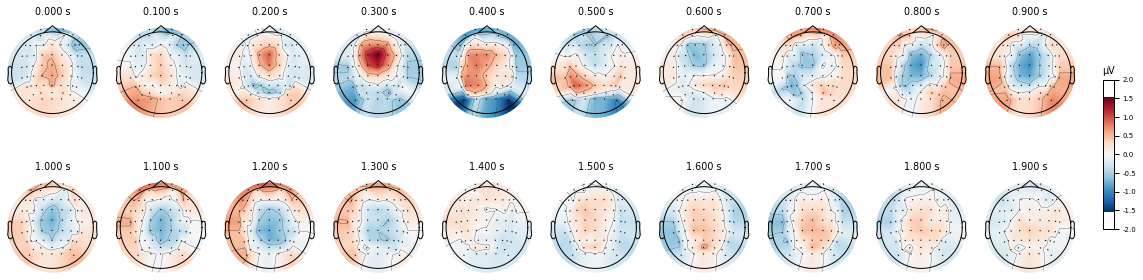

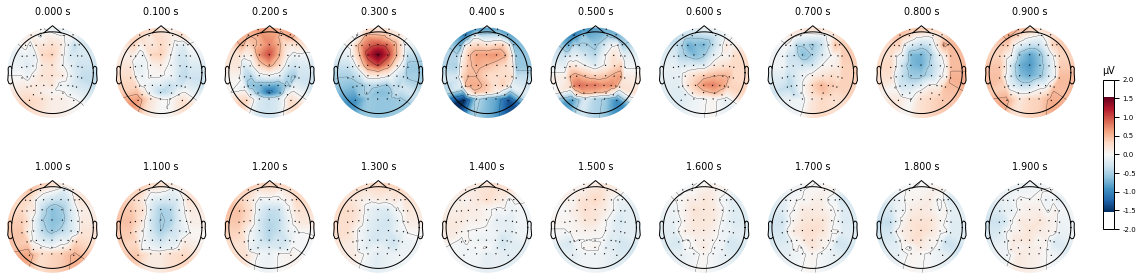

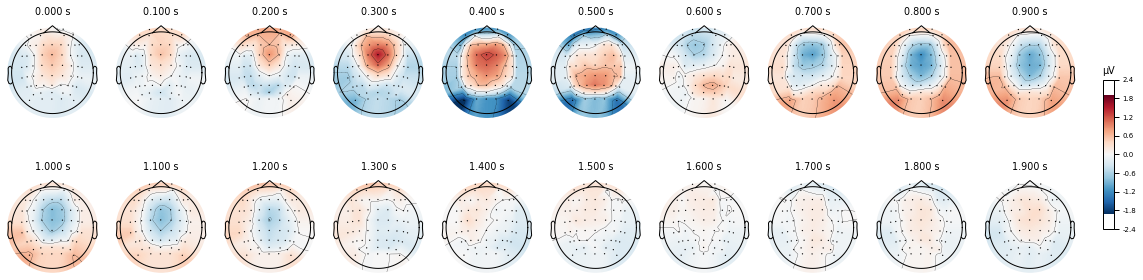

In [51]:
# Topoplots:
# Load all grand averages:
grand_avg_all_cond = np.load(f'{path_to_results}/grand-avg_{alignment}_All-conditions.npy')
grand_avg_short = np.load(f'{path_to_results}/grand-avg_{alignment}_Short-dist.npy')
grand_avg_long = np.load(f'{path_to_results}/grand-avg_{alignment}_Long-dist.npy')

# Load example epo for channels list:
epochs = mne.read_epochs(f'{path_to_results}/sample-epoch_{alignment}_epo.fif', preload=True)

def create_topoplot(ga, align, epo):
    # Add grand average into mne structure:
    n_chan, n_times = epo.info['nchan'], epo.times.shape[0]
    grand_avg_extended = ga.reshape((1, n_chan, n_times))

    if align == 'cue-aligned':
        grand_avg_epochs = mne.EpochsArray(grand_avg_extended, epochs.info, tmin=epochs.tmin-2.0)
        times = np.arange(0.0, 2.0, 0.1)
    elif align == 'movement-aligned':
        grand_avg_epochs = mne.EpochsArray(grand_avg_extended, epochs.info, tmin=epochs.tmin)
        times = np.arange(-1.0, 1.0, .1)

    return grand_avg_epochs.average().plot_topomap(times, ch_type='eeg', ncols=10,
                                                  nrows='auto', image_interp='linear')#, scalings=dict(eeg=1e-6))#, units='a.u.', vlim=(0, 1))

fig = create_topoplot(grand_avg_all_cond, alignment, epochs)
fig.savefig(f'{path_to_figs}/grand_average_topo_{alignment}_all-conditions.png', bbox_inches='tight', dpi=300)

fig = create_topoplot(grand_avg_short, alignment, epochs)
fig.savefig(f'{path_to_figs}/grand_average_topo_{alignment}_short.png', bbox_inches='tight', dpi=300)

fig = create_topoplot(grand_avg_long, alignment, epochs)
fig.savefig(f'{path_to_figs}/grand_average_topo_{alignment}_long.png', bbox_inches='tight', dpi=300)

In [25]:
from tqdm import tqdm
p_list = []
for ch_idx in tqdm(range(len(channels))):

    shorts_per_subject = [sbj_short_avgs[i][ch_idx,:] for i in range(len(subjects))]
    shorts_per_subject = np.vstack(shorts_per_subject)
    longs_per_subject = [sbj_long_avgs[i][ch_idx,:] for i in range(len(subjects))]
    longs_per_subject = np.vstack(longs_per_subject)
    pvals = np.ones((shorts_per_subject.shape[1]))

    for ts in range(shorts_per_subject.shape[1]):
        # res = wilcoxon(shorts_per_subject[:,ts], longs_per_subject[:,ts])
        # pvals[ts] = res.pvalue
        # pvals[ts] = two_sample_permutation_test(shorts_per_subject[:,ts], longs_per_subject[:,ts])
        pvals[ts] = one_sample_permutation_test(shorts_per_subject[:,ts] - longs_per_subject[:,ts])
        # if ts % 100 == 0:
        #     print(ts)
    p_list.append(pvals)

100%|██████████| 61/61 [09:58<00:00,  9.81s/it]


In [17]:
p_cue_aligned = p_list

In [26]:
p_mov_aligned = p_list

In [27]:
count_cue_aligned = []
count_mov_aligned = []
for i in tqdm(range(len(p_cue_aligned))):
    pbin = p_cue_aligned[i] < 0.05
    count_cue_aligned.append(len(np.where(pbin==True)[0]))

    pbin = p_mov_aligned[i] < 0.05
    count_mov_aligned.append(len(np.where(pbin==True)[0]))

100%|██████████| 61/61 [00:00<?, ?it/s]


In [39]:
from tqdm import tqdm
p_list = []

shorts_per_subject = [sbj_short_avgs[i][ch_idx,:] for i in range(len(subjects))]
shorts_per_subject = np.vstack(shorts_per_subject)
longs_per_subject = [sbj_long_avgs[i][ch_idx,:] for i in range(len(subjects))]
longs_per_subject = np.vstack(longs_per_subject)
pvals = np.ones((shorts_per_subject.shape[1]))

for ts in tqdm(range(shorts_per_subject.shape[1])):
    # res = wilcoxon(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    # pvals[ts] = res.pvalue
    # pvals[ts] = two_sample_permutation_test(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    _stat, orig_stat = two_sample_permutation_test(shorts_per_subject[:,ts], longs_per_subject[:,ts])
    # if ts % 100 == 0:
    #     print(ts)
p_list.append(pvals)

100%|██████████| 1401/1401 [01:43<00:00, 13.49it/s]


(array([4.000e+00, 1.200e+01, 2.400e+01, 6.300e+01, 1.800e+02, 5.050e+02,
        1.039e+03, 1.906e+03, 2.292e+03, 1.937e+03, 1.179e+03, 5.280e+02,
        2.110e+02, 7.300e+01, 2.300e+01, 1.300e+01, 5.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00]),
 array([-5.15753143, -4.55350864, -3.94948585, -3.34546306, -2.74144027,
        -2.13741747, -1.53339468, -0.92937189, -0.3253491 ,  0.27867369,
         0.88269648,  1.48671927,  2.09074206,  2.69476486,  3.29878765,
         3.90281044,  4.50683323,  5.11085602,  5.71487881,  6.3189016 ,
         6.92292439]),
 <BarContainer object of 20 artists>)

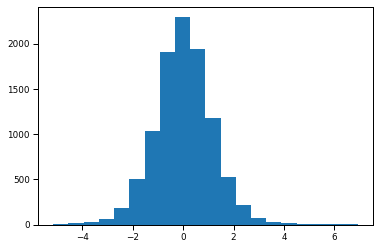

In [47]:
perm_hist = np.histogram(_stat)
_stat.sort()

plt.hist(_stat, bins=20)

# 4. Classification results

In [7]:
# Load classification results:
df_subject_class = pd.read_csv(f'{path_to_results}/classification_df.csv', index_col=0)
df_class_mean = pd.read_csv(f'{path_to_results}/classification_means_ci.csv', index_col=0)

# Load chance_level results:
df_sbj_chance = pd.read_csv(f'{path_to_results}/subject_specific_chance_level.csv', index_col=0)
df_overall_chance = pd.read_csv(f'{path_to_results}/overall_chance_level.csv', index_col=0)

Max acc: 0.36 at ts 0.4 direction cue-aligned 1
Sec max acc: 0.3 at ts 4.4
Chance level: 0    0.303214
Name: Overall_chance, dtype: float64


100%|██████████| 70/70 [00:01<00:00, 48.68it/s]


direction_cue-aligned_1


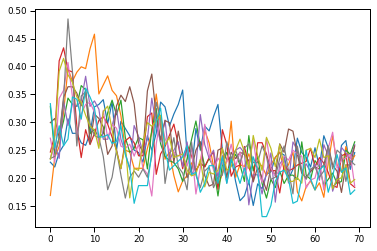

Significant span: -1.7 to -1.5
Significant span: -1.2 to -1.2


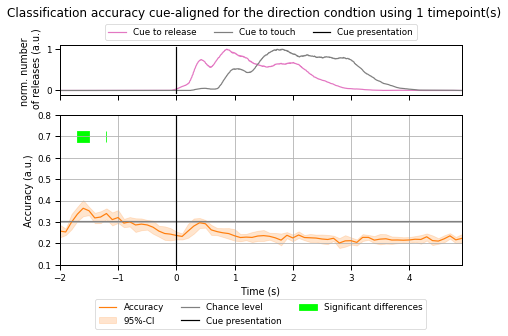

Max acc: 0.41 at ts 0.8 direction cue-aligned 6
Sec max acc: 0.3 at ts 4.7
Chance level: 1    0.304359
Name: Overall_chance, dtype: float64


100%|██████████| 65/65 [00:01<00:00, 59.43it/s]


direction_cue-aligned_6


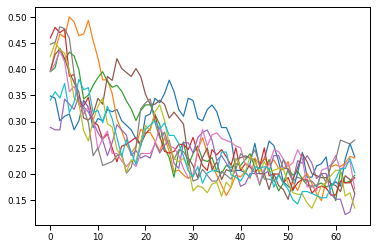

Significant span: -1.5 to -0.7


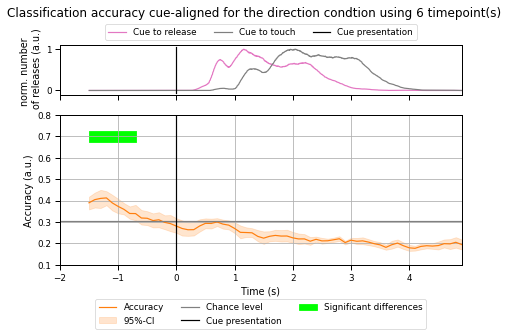

Max acc: 0.43 at ts 0.2000000000000001 direction movement_aligned 1
Sec max acc: 0.43 at ts 2.2
Chance level: 2    0.302037
Name: Overall_chance, dtype: float64


100%|██████████| 60/60 [00:00<00:00, 61.87it/s]


direction_movement_aligned_1


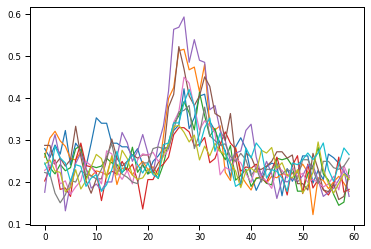

Significant span: 0.0 to 0.6


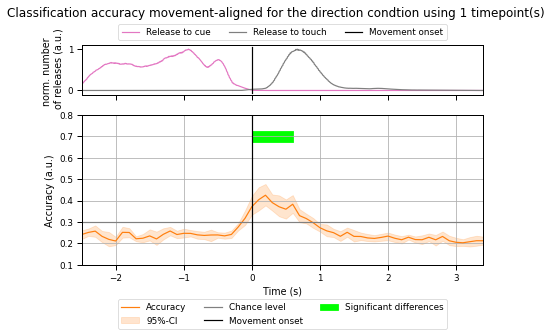

Max acc: 0.46 at ts 0.5 direction movement_aligned 6
Sec max acc: 0.46 at ts 2.5
Chance level: 3    0.304506
Name: Overall_chance, dtype: float64


100%|██████████| 55/55 [00:00<00:00, 64.01it/s]


direction_movement_aligned_6


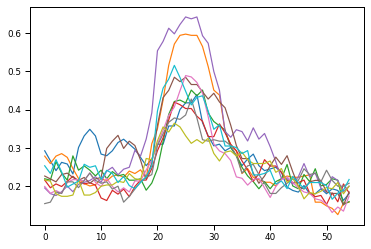

Significant span: 0.1 to 1.2


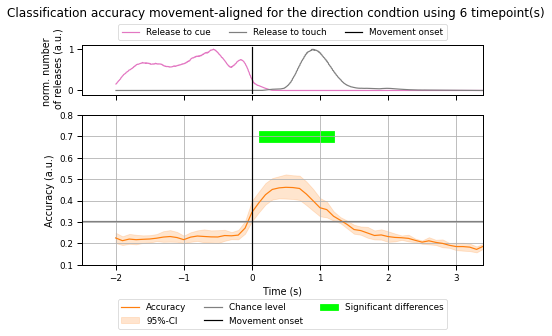

Max acc: 0.41 at ts 0.4 direction_long cue-aligned 1
Sec max acc: 0.38 at ts 4.4
Chance level: 4    0.325097
Name: Overall_chance, dtype: float64


100%|██████████| 70/70 [00:01<00:00, 56.72it/s]


direction_long_cue-aligned_1


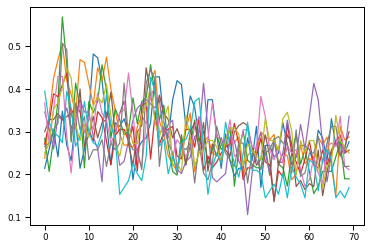

Significant span: -1.6 to -1.5
Significant span: 0.4 to 0.5


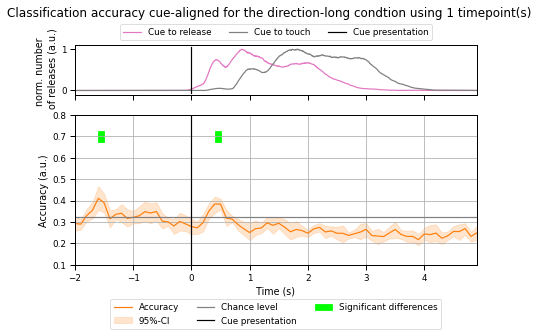

Max acc: 0.48 at ts 0.8 direction_long cue-aligned 6
Sec max acc: 0.44 at ts 4.8
Chance level: 5    0.323771
Name: Overall_chance, dtype: float64


100%|██████████| 65/65 [00:01<00:00, 57.00it/s]


direction_long_cue-aligned_6


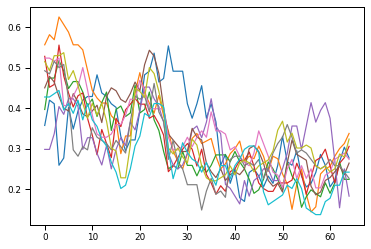

Significant span: -1.5 to -0.2
Significant span: 0.3 to 1.0


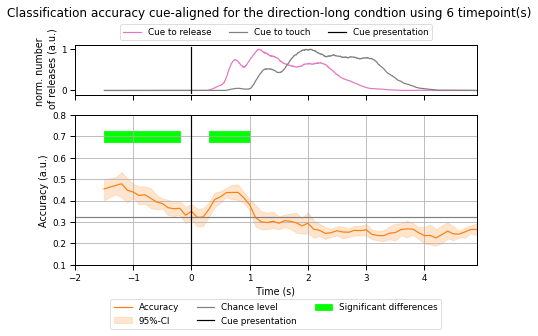

Max acc: 0.52 at ts 0.2000000000000001 direction_long movement_aligned 1
Sec max acc: 0.52 at ts 2.2
Chance level: 6    0.326139
Name: Overall_chance, dtype: float64


100%|██████████| 60/60 [00:00<00:00, 66.20it/s]


direction_long_movement_aligned_1


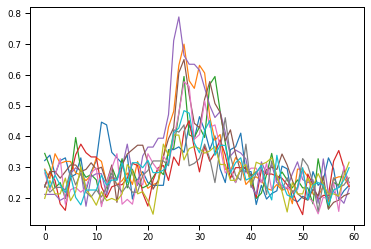

Significant span: 0.0 to 0.9


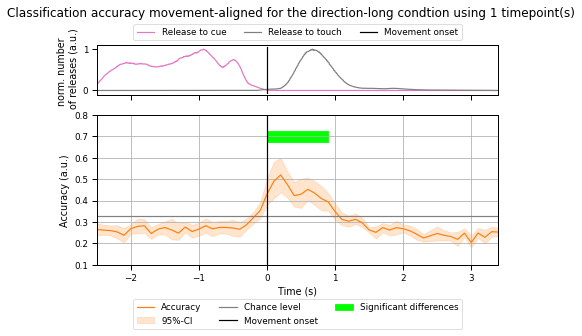

Max acc: 0.62 at ts 0.5 direction_long movement_aligned 6
Sec max acc: 0.62 at ts 2.5
Chance level: 7    0.323581
Name: Overall_chance, dtype: float64


100%|██████████| 55/55 [00:00<00:00, 73.30it/s]


direction_long_movement_aligned_6


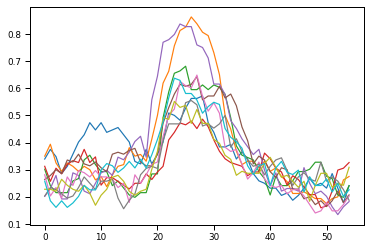

Significant span: 0.0 to 1.5


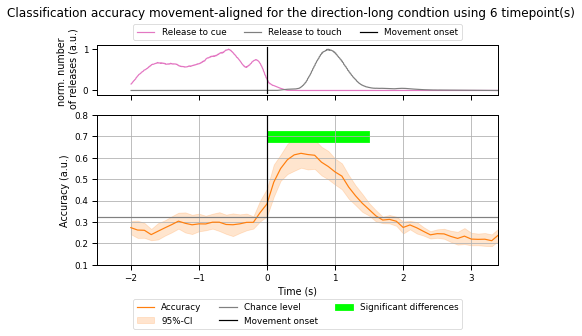

Max acc: 0.39 at ts 0.3 direction_short cue-aligned 1
Sec max acc: 0.32 at ts 4.4
Chance level: 8    0.326305
Name: Overall_chance, dtype: float64


100%|██████████| 70/70 [00:01<00:00, 66.85it/s]


direction_short_cue-aligned_1


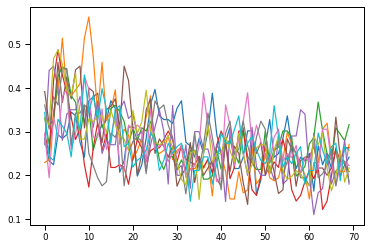

Significant span: -1.7 to -1.5
Significant span: -1.3 to -1.3


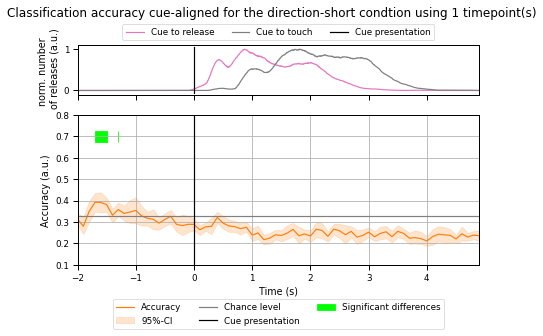

Max acc: 0.51 at ts 0.7 direction_short cue-aligned 6
Sec max acc: 0.32 at ts 4.8
Chance level: 9    0.32591
Name: Overall_chance, dtype: float64


100%|██████████| 65/65 [00:01<00:00, 64.01it/s]


direction_short_cue-aligned_6


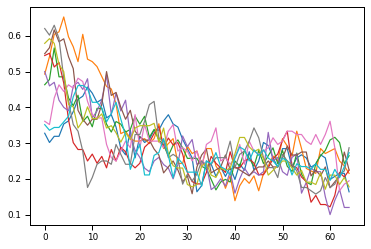

Significant span: -1.5 to -0.6
Significant span: -0.4 to -0.3


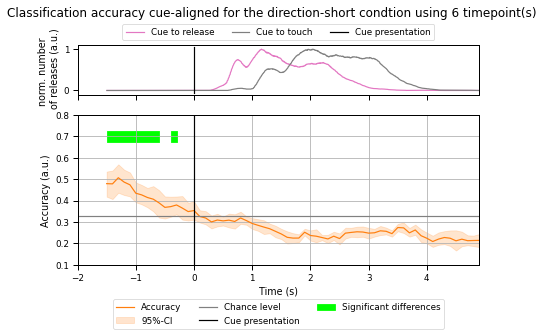

Max acc: 0.45 at ts 0.2000000000000001 direction_short movement_aligned 1
Sec max acc: 0.45 at ts 2.2
Chance level: 10    0.326497
Name: Overall_chance, dtype: float64


100%|██████████| 60/60 [00:00<00:00, 71.03it/s]


direction_short_movement_aligned_1


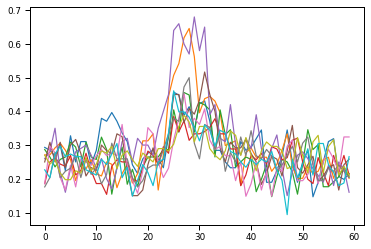

Significant span: 0.0 to 0.7


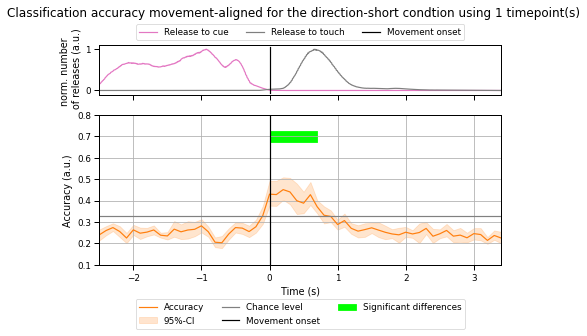

Max acc: 0.55 at ts 0.5 direction_short movement_aligned 6
Sec max acc: 0.55 at ts 2.5
Chance level: 11    0.325235
Name: Overall_chance, dtype: float64


100%|██████████| 55/55 [00:00<00:00, 81.87it/s]


direction_short_movement_aligned_6


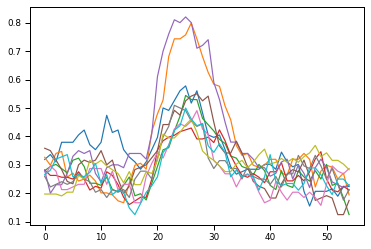

Significant span: 0.1 to 1.1


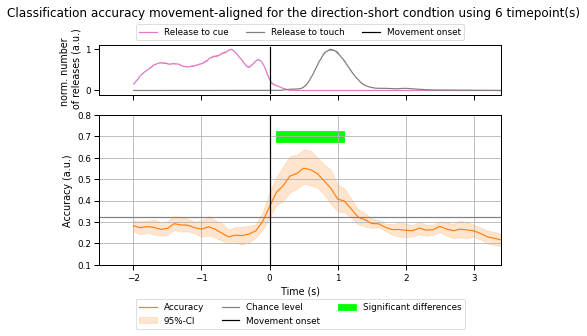

Max acc: 0.61 at ts 2.4 distance cue-aligned 1
Sec max acc: 0.61 at ts 4.4
Chance level: 12    0.562479
Name: Overall_chance, dtype: float64


100%|██████████| 70/70 [00:00<00:00, 77.26it/s]


distance_cue-aligned_1


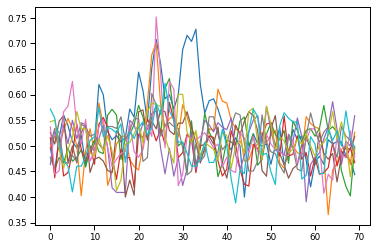

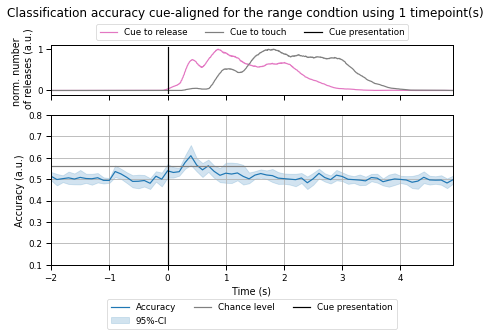

Max acc: 0.64 at ts 2.8 distance cue-aligned 6
Sec max acc: 0.64 at ts 4.8
Chance level: 13    0.562276
Name: Overall_chance, dtype: float64


100%|██████████| 65/65 [00:00<00:00, 71.71it/s]


distance_cue-aligned_6


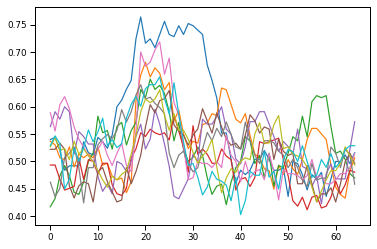

Significant span: 0.4 to 0.9


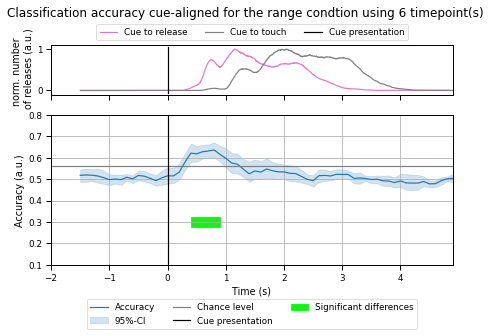

Max acc: 0.63 at ts 0.7999999999999998 distance movement_aligned 1
Sec max acc: 0.63 at ts 2.8
Chance level: 14    0.561801
Name: Overall_chance, dtype: float64


100%|██████████| 60/60 [00:00<00:00, 76.74it/s]


distance_movement_aligned_1


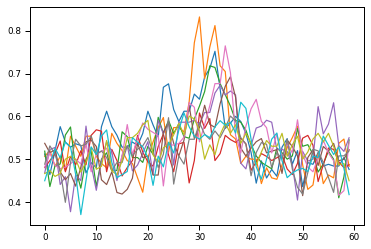

Significant span: 0.5 to 1.2


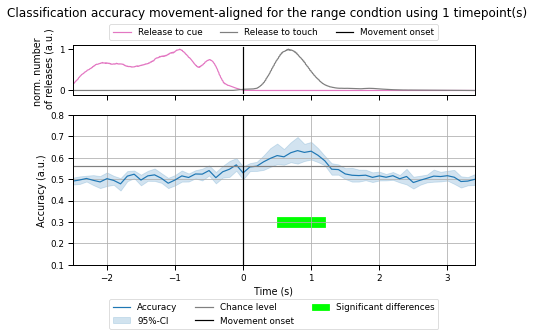

Max acc: 0.69 at ts 1.1 distance movement_aligned 6
Sec max acc: 0.69 at ts 3.1
Chance level: 15    0.560827
Name: Overall_chance, dtype: float64


100%|██████████| 55/55 [00:00<00:00, 97.80it/s] 


distance_movement_aligned_6


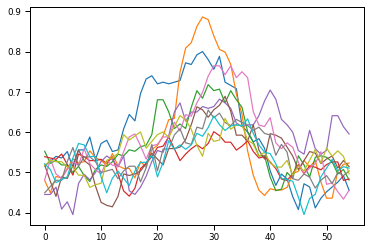

Significant span: 0.2 to 1.6


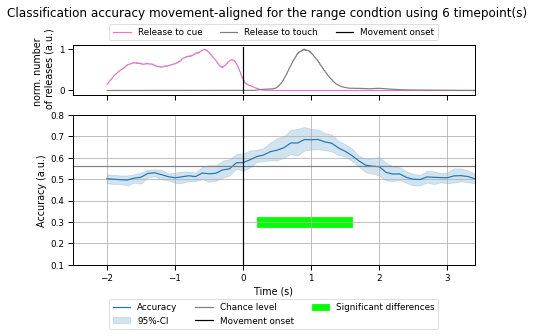

Max acc: 0.31 at ts 2.4 position cue-aligned 1
Sec max acc: 0.31 at ts 4.4
Chance level: 16    0.263726
Name: Overall_chance, dtype: float64


100%|██████████| 70/70 [00:00<00:00, 97.39it/s] 


position_cue-aligned_1


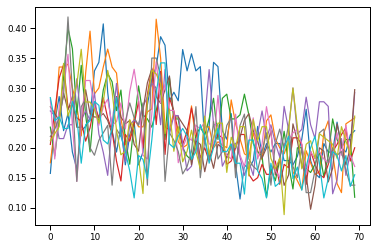

Significant span: 0.3 to 0.5


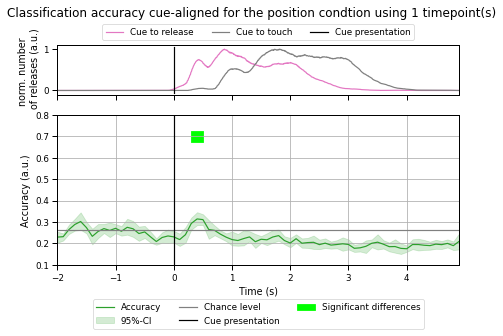

Max acc: 0.39 at ts 2.7 position cue-aligned 6
Sec max acc: 0.39 at ts 4.7
Chance level: 17    0.262155
Name: Overall_chance, dtype: float64


100%|██████████| 65/65 [00:00<00:00, 83.21it/s]


position_cue-aligned_6


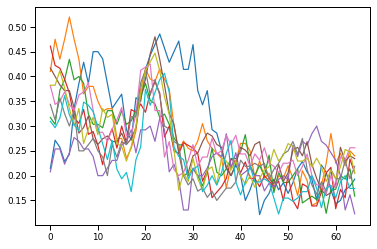

Significant span: -1.5 to -0.6
Significant span: -0.2 to -0.2
Significant span: 0.3 to 1.0


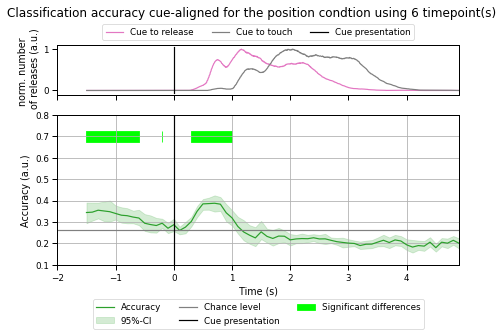

Max acc: 0.4 at ts 0.2000000000000001 position movement_aligned 1
Sec max acc: 0.4 at ts 2.2
Chance level: 18    0.262037
Name: Overall_chance, dtype: float64


100%|██████████| 60/60 [00:00<00:00, 81.32it/s]


position_movement_aligned_1


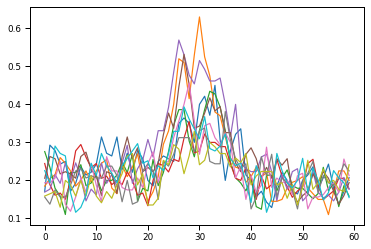

Significant span: 0.0 to 1.0


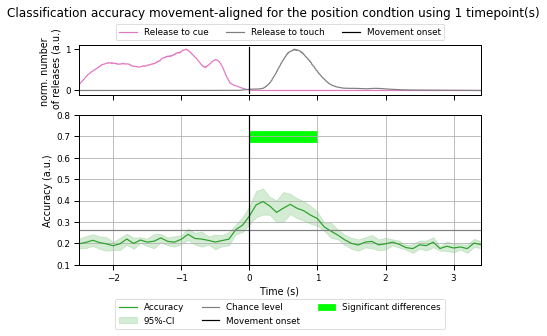

Max acc: 0.5 at ts 0.7000000000000002 position movement_aligned 6
Sec max acc: 0.5 at ts 2.7
Chance level: 19    0.262115
Name: Overall_chance, dtype: float64


100%|██████████| 55/55 [00:00<00:00, 81.78it/s]


position_movement_aligned_6


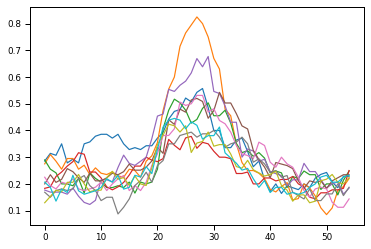

Significant span: 0.0 to 1.6


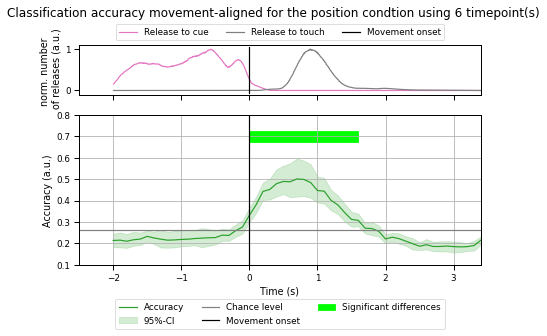

In [8]:
color_dict = {'distance': 'tab:blue', 'direction': 'tab:orange', 'direction_long': 'tab:orange', 'direction_short': 'tab:orange', 'position': 'tab:green'}

for condition in df_overall_chance['Condition'].unique():
    for type in df_overall_chance['Type'].unique():
        for n_timepoints in df_overall_chance['N_timepoints'].unique():
            y = df_class_mean[(df_class_mean['Condition'] == condition) & (df_class_mean['Type'] == type) & (df_class_mean['N_timepoints'] == n_timepoints)]['Mean_accuracy'].to_list()
            x = df_class_mean[(df_class_mean['Condition'] == condition) & (df_class_mean['Type'] == type) & (df_class_mean['N_timepoints'] == n_timepoints)]['Timepoint'].to_list()

            upper = df_class_mean[(df_class_mean['Condition'] == condition) & (df_class_mean['Type'] == type) & (df_class_mean['N_timepoints'] == n_timepoints)]['Upper'].to_list()
            lower = df_class_mean[(df_class_mean['Condition'] == condition) & (df_class_mean['Type'] == type) & (df_class_mean['N_timepoints'] == n_timepoints)]['Lower'].to_list()

            chance_level = df_overall_chance[(df_overall_chance['Condition'] == condition) & (df_overall_chance['Type'] == type) & (df_overall_chance['N_timepoints'] == n_timepoints)]['Overall_chance']

            print(f'Max acc: {round(max(y),2)} at ts {x[y.index(max(y))]} {condition} {type} {n_timepoints}')
            print(f'Sec max acc: {round(max(y[20:]),2)} at ts {x[y.index(max(y[20:]))+20]}')
            print(f'Chance level: {chance_level}')

            pvals = np.ones((len(x)))
            for i,tp in enumerate(tqdm(x)):
                # Extract subject accuracies to test against chance level:
                sbj_accs = np.array(df_subject_class[(df_subject_class['Condition'] == condition) & (df_subject_class['Type'] == type) & (df_subject_class['N_timepoints'] == n_timepoints) & (df_subject_class['Timepoint'] == tp)]['Accuracy'])

                pvals[i] = one_sided_one_sample_perm(sbj_accs, chance_level.values[0])

            print(f'{condition}_{type}_{n_timepoints}')
            for s in df_subject_class['Subject'].unique():
                plt.plot(np.array(df_subject_class[(df_subject_class['Condition'] == condition) & (df_subject_class['Type'] == type) & (df_subject_class['N_timepoints'] == n_timepoints) & (df_subject_class['Subject'] == s)]['Accuracy']))
            plt.show()

            # Create binary p-val array:
            p_bin = pvals < 0.05 #/shorts_per_subject.shape[1]
            # Get ids where p_bin is true:
            p_ids = np.where(p_bin==True)


            if type == 'cue-aligned':
                x = [i-2.0 for i in x]

            # Make figure:
            fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [1, 3]}, sharex='col', figsize=(7.2,4.05))

            ax[1].plot(x,y, color=color_dict[condition])
            ax[1].fill_between(x, lower, upper, alpha=0.2, color=color_dict[condition])
            if n_timepoints == 6:
                ax[1].plot([x[0]-0.5, x[-1]], [chance_level, chance_level], color='grey')
            else:
                ax[1].plot([x[0], x[-1]], [chance_level, chance_level], color='grey')

            ax[1].plot([0.0, 0.0], [0.1, 0.8], 'black')

            if type == 'cue-aligned':
                legend_text = ['Accuracy', '95%-CI', 'Chance level', 'Cue presentation']
            else:
                legend_text = ['Accuracy', '95%-CI', 'Chance level', 'Movement onset']

            if 'distance' in condition:
                y_plot = 0.3
            else:
                y_plot = 0.7
            in_draw = False
            never_draw = True
            for i in range(len(p_bin)):
                if p_bin[i] and not in_draw:
                    never_draw = False
                    in_draw = True
                    start_x = x[i]
                if not p_bin[i] and in_draw:
                    in_draw = False
                    ax[1].fill_between([start_x, x[i-1]], y_plot-0.025, y_plot+0.025, color='lime')
                    print(f'Significant span: {round(start_x,2)} to {round(x[i-1],2)}')
            if in_draw:
                ax[1].fill_between([start_x, x[i]], y_plot-0.025, y_plot+0.025, color='lime')
                print(f'Significant span: {round(start_x,2)} to {round(x[i],2)}')



            if not never_draw:
                legend_text.append('Significant differences')
            else:
                legend_text.append('Significant differences')

            ax[1].legend(legend_text, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=3)

            ax[1].set_ylim([0.1, 0.8])
            if n_timepoints == 6:
                ax[1].set_xlim([x[0]-0.5, x[-1]])
                ax[0].set_xlim([x[0]-0.5, x[-1]])
            else:
                ax[1].set_xlim([x[0], x[-1]])
                ax[0].set_xlim([x[0], x[-1]])
            ax[1].set_ylabel('Accuracy (a.u.)')
            ax[1].set_xlabel('Time (s)')
            ax[1].grid(True, which='major')

            if type == 'movement_aligned':
                tmp_type = 'movement-aligned'
            else:
                tmp_type = 'cue-aligned'
            smoothed_cue_release, smoothed_second = get_smoothed_timings(alignment=tmp_type)

            step = (x[-1] - x[0])/(len(smoothed_cue_release)+1)
            x_timings = np.arange(x[0], x[-1] + step, step)
            if tmp_type == 'cue-aligned':
                ax[0].plot(x_timings[1:-1], smoothed_cue_release, color='C6')
                ax[0].plot(x_timings[1:-1], smoothed_second, color='C7')
                ax[0].plot([0.0, 0.0], ax[0].get_ylim(), 'black')
                ax[0].legend(['Cue to release', 'Cue to touch', 'Cue presentation'], loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=3)

            if tmp_type == 'movement-aligned':
                ax[0].plot(x_timings[1:-1], smoothed_cue_release, color='C6')
                ax[0].plot(x_timings[1:-1], smoothed_second, color='C7')
                ax[0].plot([0.0, 0.0], ax[0].get_ylim(), 'black')
                ax[0].legend(['Release to cue', 'Release to touch', 'Movement onset'], loc='upper center', bbox_to_anchor=(0.5, 1.5), fancybox=True, ncol=3)



            # ax[0].set(frame_on=False)y
            # ax[0].get_yaxis().set_visible(False)
            ax[0].grid(True, which='minor')
            ax[0].set_ylabel('norm. number \n of releases (a.u.)', labelpad=4.0)

            if type == 'movement_aligned':
                tmp_type = 'movement-aligned'
            else:
                tmp_type = 'cue-aligned'

            if condition == 'distance':
                tmp_cond = 'range'
            elif condition == 'direction_long':
                tmp_cond = 'direction-long'
            elif condition == 'direction_short':
                tmp_cond = 'direction-short'
            elif condition == 'direction':
                tmp_cond = 'direction'
            elif condition == 'position':
                tmp_cond = 'position'

            fig.suptitle(f'Classification accuracy {tmp_type} for the {tmp_cond} condtion using {n_timepoints} timepoint(s)', y=1.01)

            plt.savefig(f'{path_to_figs}/classification-result_{tmp_type}_{condition}_{n_timepoints}_timepoints.png', bbox_inches='tight', dpi=300)
            plt.savefig(f'{path_to_figs}/classification-result_{tmp_type}_{condition}_{n_timepoints}_timepoints.svg', bbox_inches='tight')
            plt.show()




## 4.1. Confusion matrices:

In [20]:
# Load classification results:
df_predictions = pd.read_csv(f'{path_to_results}/prediction_df_dir.csv', index_col=0)
df_subject_class = pd.read_csv(f'{path_to_results}/classification_df.csv', index_col=0)

C:\Users\peter\AppData\Local\Temp\ipykernel_3992\2865496363.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
C:\Users\peter\AppData\Local\Temp\ipykernel_3992\2865496363.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)
C:\Users\peter\AppData\Local\Temp\ipykernel_3992\2865496363.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
C:\Users\peter\AppData\Local\Temp\ipykernel_3992\2865496363.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)
C:\Users\peter\AppData\Local\Temp\ipykernel_3992\2865496363.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
C:\Users\peter\AppData\Local\Temp\ipykernel_3992\2865496363.py:31: UserWarning: FixedFormatter should only be used toget

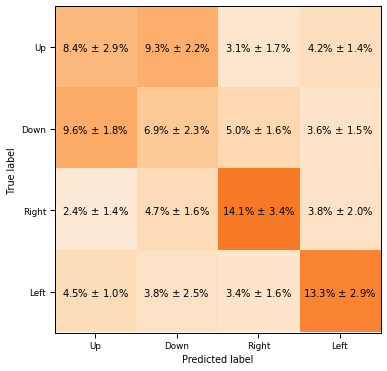

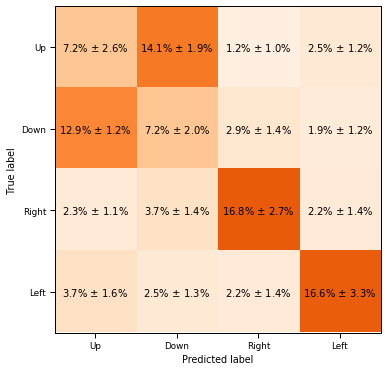

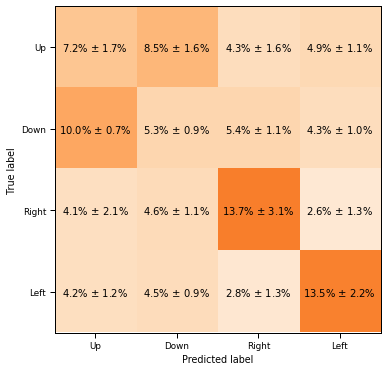

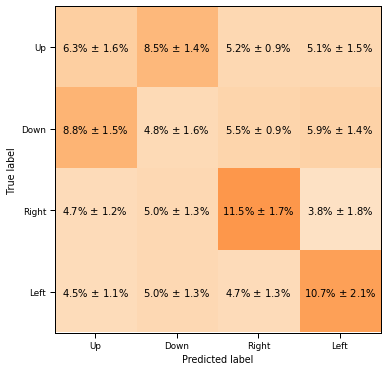

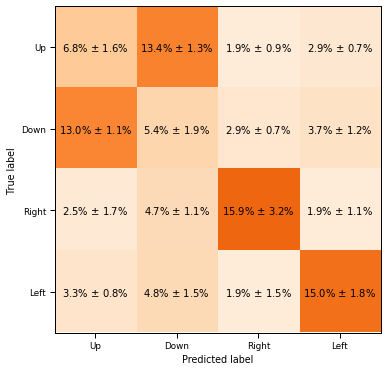

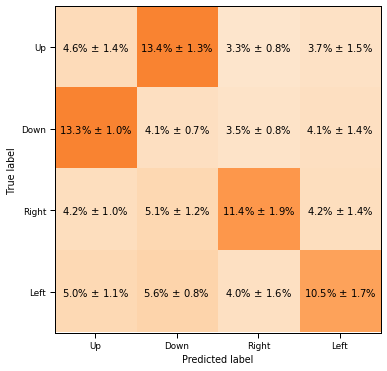

In [21]:
# Get peak accuracies:
# Movement-aligned between 0 and 2 seconds
# Cue-aligned between 0 and 1.5 seconds and 2 to 3.5 seconds
for c in df_predictions['Condition'].unique():
    for t in df_predictions['Type'].unique():
        for n in df_predictions['N_timepoints'].unique():
            all_conf1 = []
            all_conf2 = []
            all_conf = []
            for s in df_subject_class['Subject'].unique():
                accs = df_subject_class[(df_subject_class['Subject'] == s) &
                                 (df_subject_class['Condition'] == c) &
                                 (df_subject_class['Type'] == t) &
                                 (df_subject_class['N_timepoints'] == n)]['Accuracy'].to_numpy()
                tps = df_subject_class[(df_subject_class['Subject'] == s) &
                                       (df_subject_class['Condition'] == c) &
                                       (df_subject_class['Type'] == t) &
                                       (df_subject_class['N_timepoints'] == n)]['Timepoint'].to_numpy()

                y_preds = df_predictions[(df_predictions['Subject'] == s) &
                                           (df_predictions['Condition'] == c) &
                                           (df_predictions['Type'] == t) &
                                           (df_predictions['N_timepoints'] == n)]['ypred'].to_list()
                y_trues = df_predictions[(df_predictions['Subject'] == s) &
                                         (df_predictions['Condition'] == c) &
                                         (df_predictions['Type'] == t) &
                                         (df_predictions['N_timepoints'] == n)]['ytrue'].to_list()
                if t == 'cue-aligned':
                    start1 = 0
                    stop1 = np.where(tps==1.5)[0][0]
                    start2 = np.where(tps==2)[0][0]
                    stop2 = np.where(tps==3.5)[0][0]
                    idx_max1 = np.argmax(accs[start1:stop1+1])
                    idx_max2 = np.argmax(accs[start2:stop2+1])

                    # print(idx_max1)

                    idx_max1 = start1 + idx_max1
                    idx_max2 = start2 + idx_max2

                    # Calc confusion matrix of subject based on prediction df:
                    y_true = y_trues[idx_max1]
                    y_true = y_true.replace('.', ',')
                    y_true = ast.literal_eval(y_true)

                    y_pred = y_preds[idx_max1]
                    y_pred = y_pred.replace('.', ',')
                    y_pred = ast.literal_eval(y_pred)

                    all_conf1.append(confusion_matrix(y_true, y_pred, normalize='all'))

                    # Calc confusion matrix of subject based on prediction df:
                    y_true = y_trues[idx_max2]
                    y_true = y_true.replace('.', ',')
                    y_true = ast.literal_eval(y_true)

                    y_pred = y_preds[idx_max2]
                    y_pred = y_pred.replace('.', ',')
                    y_pred = ast.literal_eval(y_pred)

                    all_conf2.append(confusion_matrix(y_true, y_pred, normalize='all'))

                else:
                    start = np.where(tps==0.0)[0][0]
                    stop = np.where(tps==1.5)[0][0]
                    idx_max = np.argmax(accs[start:stop+1])
                    idx_max = start + idx_max

                    # Calc confusion matrix of subject based on prediction df:
                    y_true = y_trues[idx_max]
                    y_true = y_true.replace('.', ',')
                    y_true = ast.literal_eval(y_true)

                    y_pred = y_preds[idx_max]
                    y_pred = y_pred.replace('.', ',')
                    y_pred = ast.literal_eval(y_pred)

                    all_conf.append(confusion_matrix(y_true, y_pred, normalize='all'))

            # Get average and std confusion matrix:
            if t == 'cue-aligned':
                avg_conf1 = np.array(all_conf1).mean(axis=0)
                std_conf1 = np.array(all_conf1).std(axis=0)
                avg_conf2 = np.array(all_conf2).mean(axis=0)
                std_conf2 = np.array(all_conf2).std(axis=0)

                fig = plot_conf_mat(avg_conf1, std_conf1, c, t, n)
                plt.savefig(f'{path_to_figs}/conf-mat_{t}_{c}_{n}_timepoints_early.png', bbox_inches='tight', dpi=300)

                fig = plot_conf_mat(avg_conf2, std_conf2, c, t, n)
                plt.savefig(f'{path_to_figs}/conf-mat_{t}_{c}_{n}_timepoints_late.png', bbox_inches='tight', dpi=300)

            else:
                avg_conf = np.array(all_conf).mean(axis=0)
                std_conf = np.array(all_conf).std(axis=0)

                fig = plot_conf_mat(avg_conf, std_conf, c, t, n)
                tmp_type = 'movement-aligned'
                plt.savefig(f'{path_to_figs}/conf-mat_{tmp_type}_{c}_{n}_timepoints.png', bbox_inches='tight', dpi=300)



In [12]:
def plot_conf_mat(mean_mat, std_mat, condition, type, ntimepoints):
    color_dict = {'distance': 'Blues', 'direction': 'Oranges', 'direction_long': 'Oranges', 'direction_short': 'Oranges', 'position': 'Greens'}
    mean_mat = mean_mat * 100
    std_mat = std_mat * 100
    if 'distance' in condition:
        vmax = 50
        labels = ['Long', 'Short']
        color = color_dict[condition]
        fig, ax = plt.subplots(figsize=(4,4))

    elif 'direction' in condition:
        vmax = 25
        labels = ['Up', 'Down', 'Right', 'Left']
        color = color_dict[condition]
        fig, ax = plt.subplots(figsize=(6,6))

    elif 'position' in condition:
        vmax = 20
        labels = ['Top', 'Bottom', 'Right', 'Left', 'Center']
        color = color_dict[condition]
        fig, ax = plt.subplots(figsize=(7,7))


    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    ax.matshow(mean_mat, cmap=color,  vmin=0, vmax=vmax)
    for (i, j), z in np.ndenumerate(mean_mat):
        ax.text(j, i, r'{:0.1f}% $\pm$ {:0.1f}%'.format(z,std_mat[i,j]), ha='center', va='center')

    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return fig

In [59]:
df_subject_class['Condition'].unique()

array(['distance', 'direction', 'direction_short', 'direction_long',
       'position'], dtype=object)

# 5. GLM results

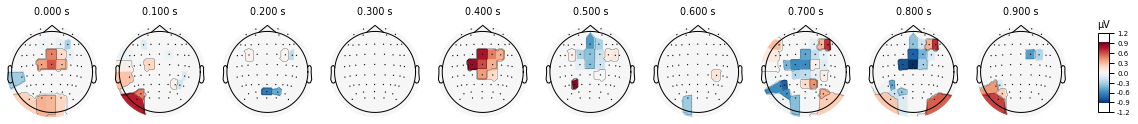

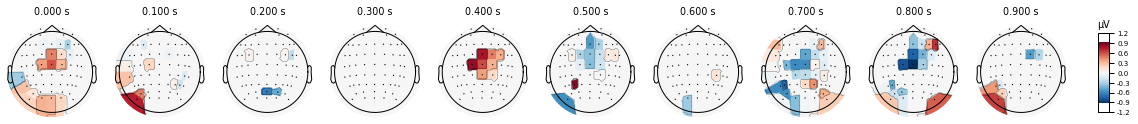

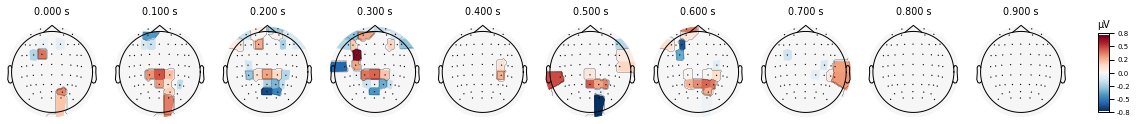

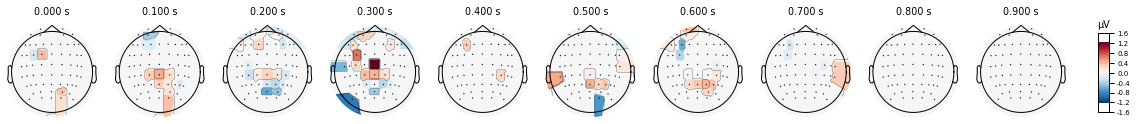

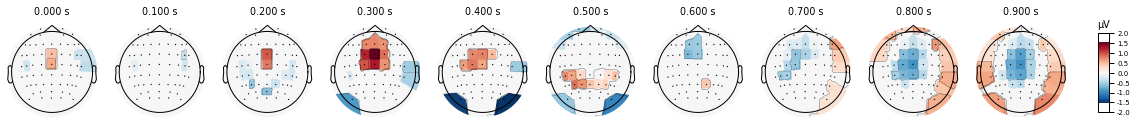

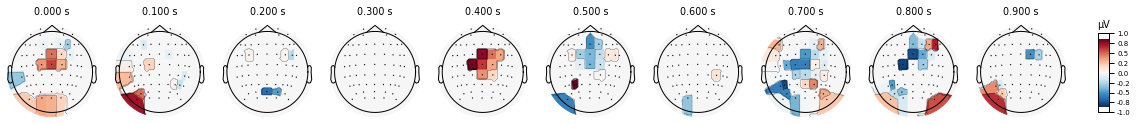

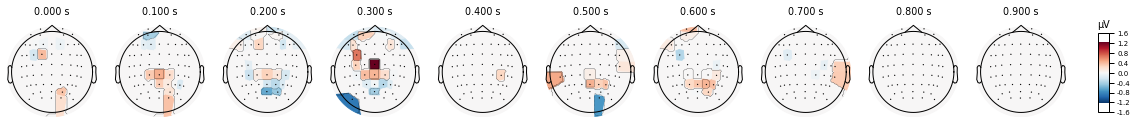

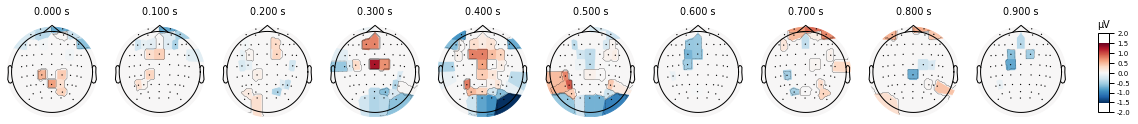

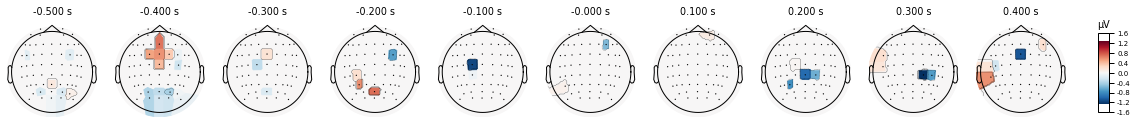

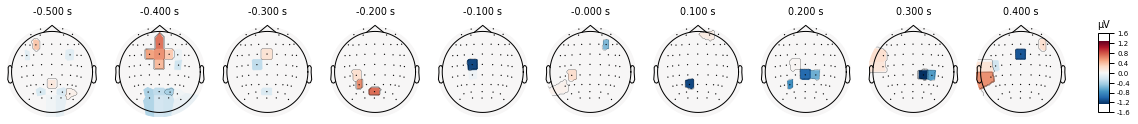

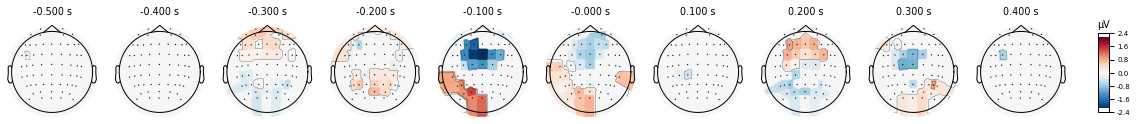

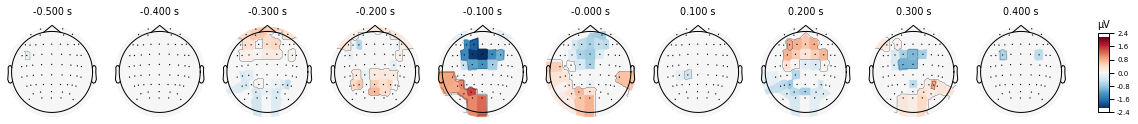

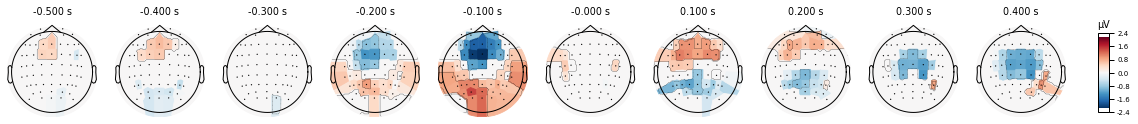

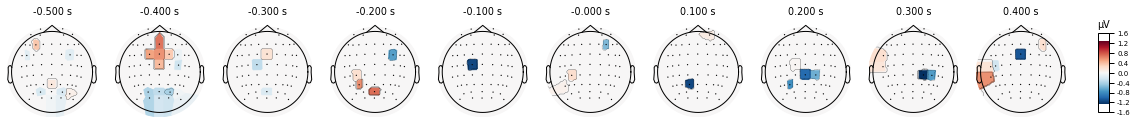

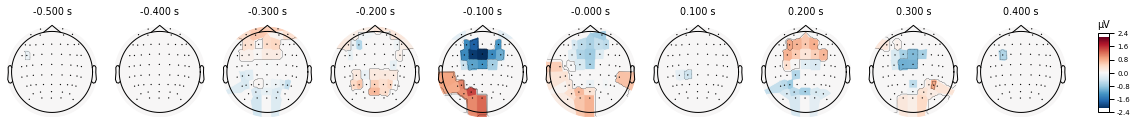

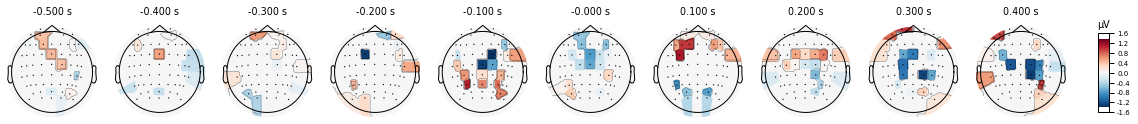

In [24]:
importlib.reload(visu)

src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='results', dst_fldr='figs')

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='cue-aligned', p_crit=.025, shrink=True, one_sample=True)

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='cue-aligned', p_crit=.025, shrink=True, one_sample=False)


avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='movement-aligned', p_crit=.025, shrink=True, one_sample=True)

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='movement-aligned', p_crit=.025, shrink=True, one_sample=False)




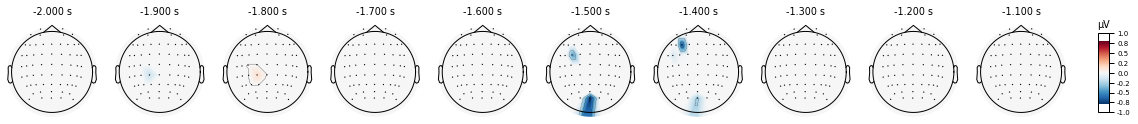

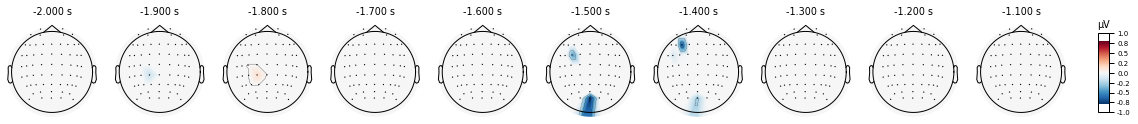

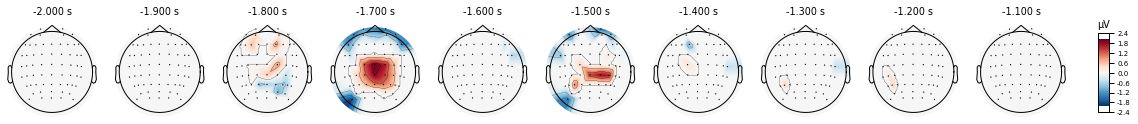

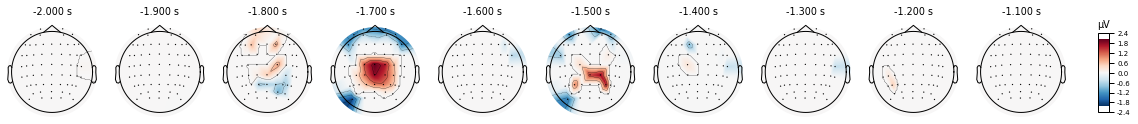

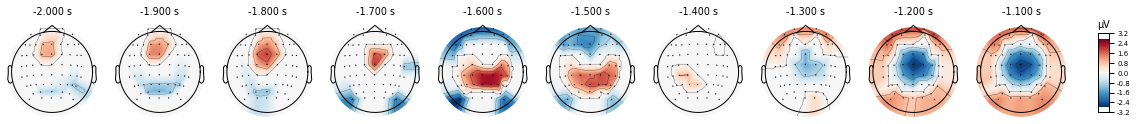

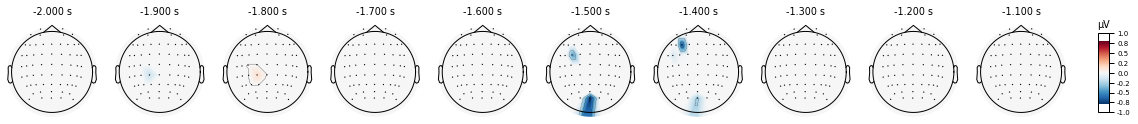

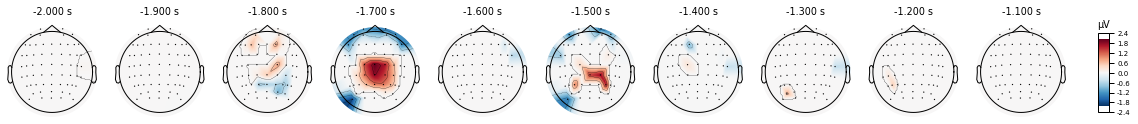

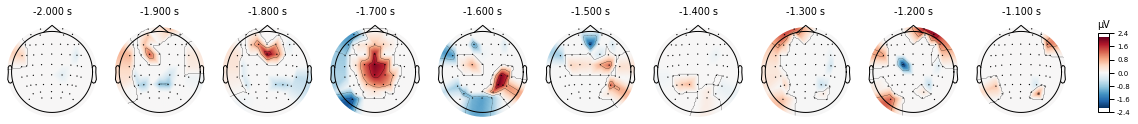

In [29]:
importlib.reload(visu)

src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='results', dst_fldr='figs')

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='cue-aligned', p_crit=.025, shrink=True, one_sample=True, early=True)

avg = visu.glm_significant_topo(src_path, dst_path, subjects, alignment='cue-aligned', p_crit=.025, shrink=True, one_sample=False, early=True)

In [20]:
p = np.load('D:/Diplomarbeit_data/eeg/results/regr-coeff-p-vals_cue-aligned_shrink.npy')
p = p[10,:,:]

In [ ]:
importlib.reload(visu)

src_path, dst_path = fh.gen_paths(pth=data_path, src_fldr='results', dst_fldr='figs3hz')

avg = visu.condition_topos(src_path, dst_path, subjects, alignment='cue-aligned', shrink=True)

In [ ]:
pvals = np.load('D:/Diplomarbeit_data/eeg/results/regr-coeff-p-vals_cue-aligned_no-shrink.npy')


(5, 61, 1401)
0
1
2
3


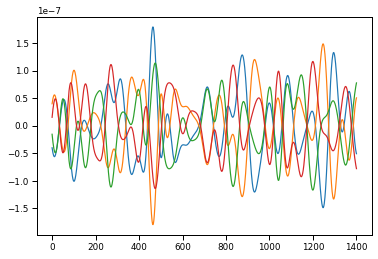

In [19]:
reg_coeff = np.load('D:/Diplomarbeit_data/eeg/results/regr-coeff_A03_cue-aligned_no-shrink.npy')

import matplotlib.pyplot as plt

print(reg_coeff.shape)
for cond in range(reg_coeff.shape[0]-1):
    print(cond)
    plt.plot(reg_coeff[cond,10,:])
plt.show()

In [ ]:
s_intercept = np.ones((1,360))

temp = np.concatenate([s_intercept.squeeze(), s_intercept.squeeze()])

# s_intercept = (s_intercept - s_intercept.mean())/s_intercept.std()

In [ ]:
X = np.array([[1,2,3],
              [4,5,6]])

Y = np.array([[2,4],
              [8,10],
              [14,16]])

In [ ]:
cx = np.cov(X.T)
cy = np.cov(Y.T)

In [ ]:
cx.dot(cy)

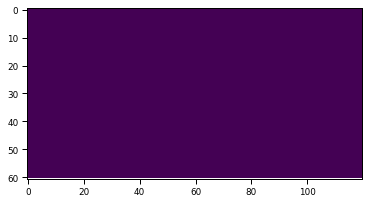

In [17]:
# Load p_vals of glm:
p_vals = np.load(f'{src_path}/regr-coeff-p-vals_movement-aligned_shrink.npy')

# Get binary mask for p_vals that are smaller than p_crit
p_crit = 0.05
p_bin = p_vals < p_crit
temp_p = p_vals[:,2,:]
import matplotlib.pyplot as plt
t = np.arange(0,1200,10)
plt.imshow(p_bin[:,0,t])

# 6. Parking lot

In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between release of the start handle and touch of the target handle')
ax.boxplot([diff_release_touch_s, diff_release_touch_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_cue-release.png', bbox_inches='tight', dpi=300)

In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between release of start handle and touch of the target handle')
ax.boxplot([diff_release_touch_s, diff_release_touch_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_release-touch.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_release_touch_s)}')
print(f'STD short: {np.std(diff_release_touch_s)}')
print(f'Mean long: {np.mean(diff_release_touch_l)}')
print(f'STD long: {np.std(diff_release_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval of two sample perm test: {two_sample_permutation_test(diff_release_touch_s, diff_release_touch_l)}')

In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between cue presentation and touch of the target handle')
ax.boxplot([diff_cue_touch_s, diff_cue_touch_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_cue-touch.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_cue_touch_s)}')
print(f'STD short: {np.std(diff_cue_touch_s)}')
print(f'Mean long: {np.mean(diff_cue_touch_l)}')
print(f'STD long: {np.std(diff_cue_touch_l)}')

# Perform permutation test on the two populations:
print(f'pval of two sample perm test: {two_sample_permutation_test(diff_cue_touch_s, diff_cue_touch_l)}')


In [ ]:
# Box plots:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Difference between cue presentation and release of the start handle')
ax.boxplot([diff_cue_release_s, diff_cue_release_l])
ax.set_ylabel('Time (s)')
ax.set_xticks([1, 2], ['short', 'long'])
plt.tight_layout()
fig.savefig(f'{path_to_figs}/boxplot_cue-aligned_cue-release.png', bbox_inches='tight', dpi=300)

# Report metrics:
print(f'Mean short: {np.mean(diff_cue_release_s)}')
print(f'STD short: {np.std(diff_cue_release_s)}')
print(f'Mean long: {np.mean(diff_cue_release_l)}')
print(f'STD long: {np.std(diff_cue_release_l)}')

# Perform permutation test on the two populations:
print(f'pval of two sample perm test: {two_sample_permutation_test(diff_cue_release_s, diff_cue_release_l)}')